## Imports

In [1]:
import pandas as pd
import os
import numpy as np
from pathlib import Path
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.transform import resize, rescale
import seaborn as sns
import random
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')
import gc
gc.enable()
import wandb
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers
import tensorflow.keras as keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import load_model

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

## Config and EDA

In [2]:
 cfg = {
    'train_path': '/kaggle/input/paddy-disease-classification/train_images/',
    'train_df_path': Path('/kaggle/input/paddy-disease-classification/train.csv'),
    'img_size': (480,480),
    'epochs': 100,
    'num_workers': 16,
    'lr':1e-03,
    'batch_size': 16,
    'device': 'cuda',
    'lr_values': [1e-2, 2e-2, 1e-3, 2e-3, 1e-4, 2e-4]
}

In [3]:
df = pd.read_csv(cfg['train_df_path'])
print(df)
print(df.info())

         image_id                  label variety  age
0      100330.jpg  bacterial_leaf_blight   ADT45   45
1      100365.jpg  bacterial_leaf_blight   ADT45   45
2      100382.jpg  bacterial_leaf_blight   ADT45   45
3      100632.jpg  bacterial_leaf_blight   ADT45   45
4      101918.jpg  bacterial_leaf_blight   ADT45   45
...           ...                    ...     ...  ...
10402  107607.jpg                 tungro   Zonal   55
10403  107811.jpg                 tungro   Zonal   55
10404  108547.jpg                 tungro   Zonal   55
10405  110245.jpg                 tungro   Zonal   55
10406  110381.jpg                 tungro   Zonal   55

[10407 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  10407 non-null  object
 1   label     10407 non-null  object
 2   variety   10407 non-null  object
 3   age       10407 non-nul

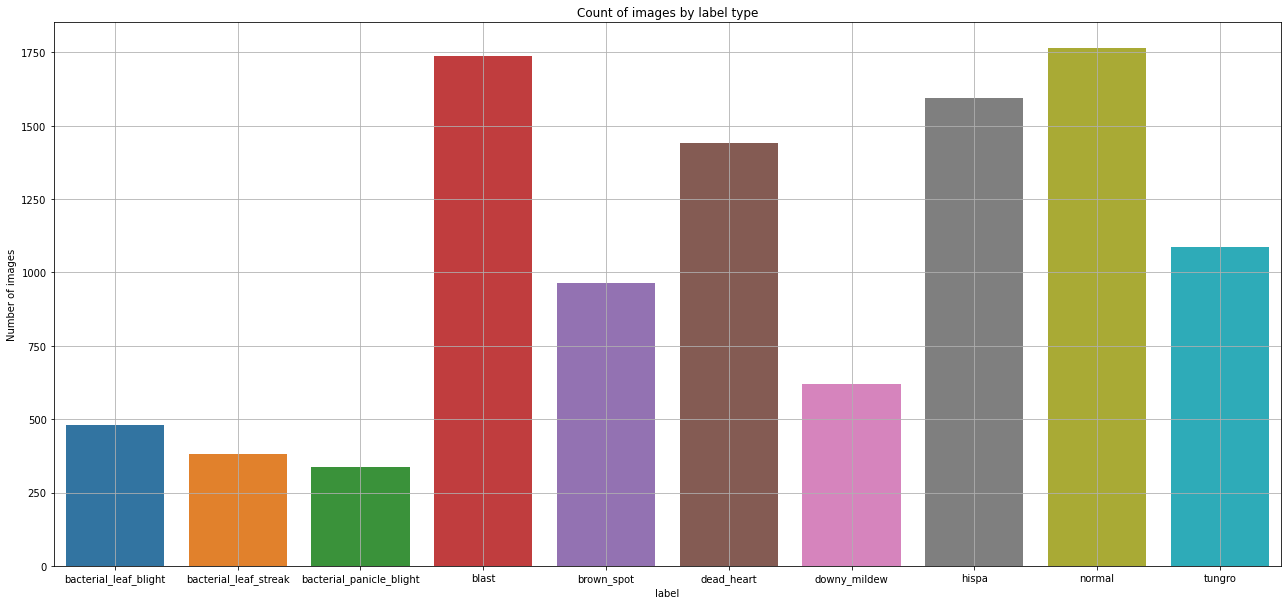

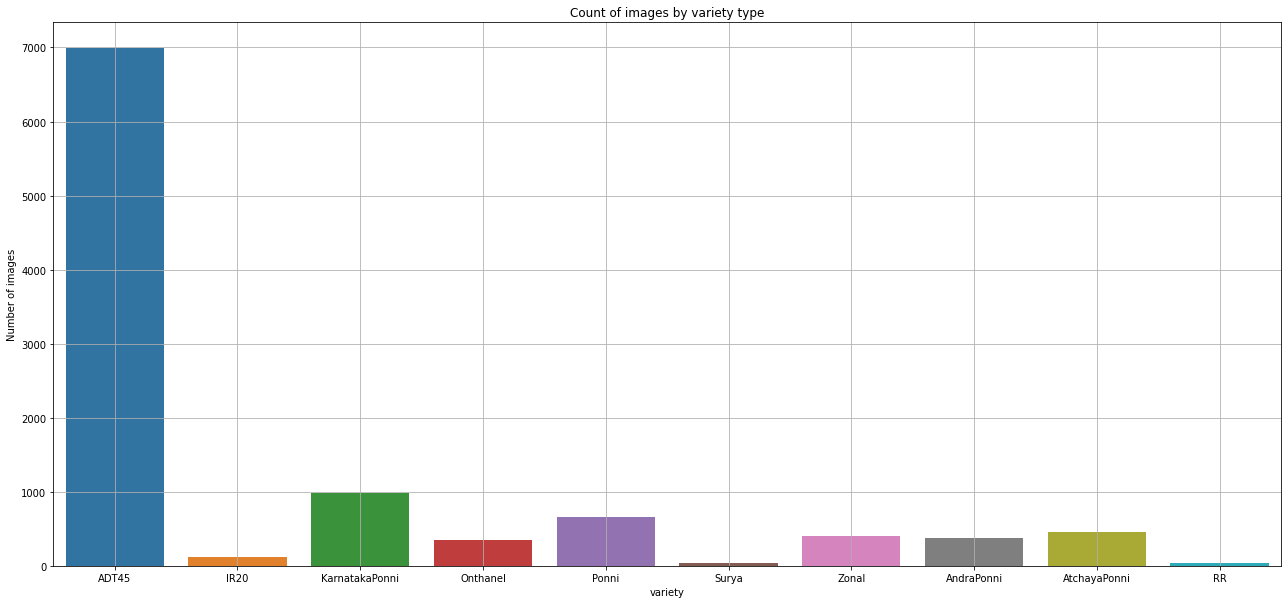

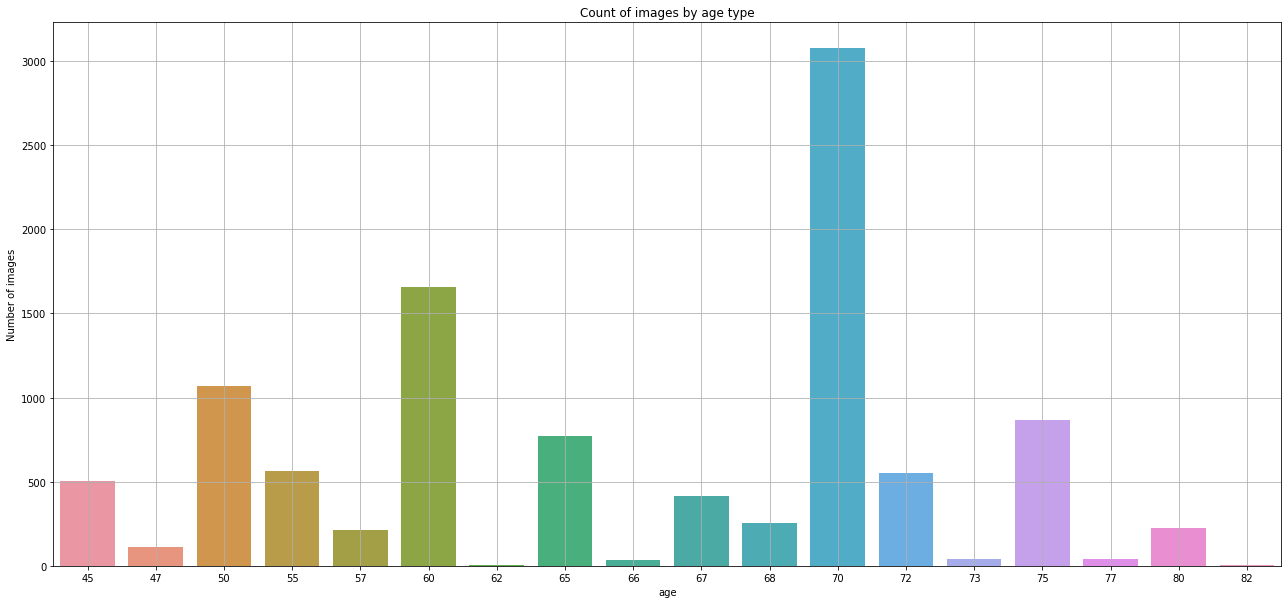

In [4]:
cols = ['label', 'variety', 'age']
for idx, col in enumerate(cols):
    plt.figure(figsize=(22,10))
    sns.countplot(x=col, data=df)
    plt.title(f"Count of images by {col} type")
    plt.ylabel("Number of images")
    plt.grid()
    plt.show()
    print('\n')

In [5]:
labels = df.label
imgs = df.image_id
df['paths'] = None
for idx in tqdm(range(len(df))):
    df.paths[idx] = str(labels[idx])+ '/' + str(imgs[idx])
df.head(10)

100%|██████████| 10407/10407 [00:04<00:00, 2578.45it/s]


,image_id,label,variety,age,paths
0,100330.jpg,bacterial_leaf_blight,ADT45,45,bacterial_leaf_blight/100330.jpg
1,100365.jpg,bacterial_leaf_blight,ADT45,45,bacterial_leaf_blight/100365.jpg
2,100382.jpg,bacterial_leaf_blight,ADT45,45,bacterial_leaf_blight/100382.jpg
3,100632.jpg,bacterial_leaf_blight,ADT45,45,bacterial_leaf_blight/100632.jpg
4,101918.jpg,bacterial_leaf_blight,ADT45,45,bacterial_leaf_blight/101918.jpg
5,102353.jpg,bacterial_leaf_blight,ADT45,45,bacterial_leaf_blight/102353.jpg
6,102848.jpg,bacterial_leaf_blight,ADT45,45,bacterial_leaf_blight/102848.jpg
7,103051.jpg,bacterial_leaf_blight,ADT45,45,bacterial_leaf_blight/103051.jpg
8,103702.jpg,bacterial_leaf_blight,ADT45,45,bacterial_leaf_blight/103702.jpg
9,103920.jpg,bacterial_leaf_blight,ADT45,45,bacterial_leaf_blight/103920.jpg


bacterial_leaf_blight
(640, 480, 3)


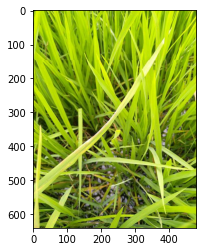

In [6]:
img = cv2.imread(os.path.join(cfg['train_path'], df.paths[1]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = cv2.resize(img, cfg['img_size'])
print(df.label[1])
plt.imshow(img)
print(img.shape)

## Creating dataset

In [7]:
encodings = {val: idx for idx, val in enumerate(df.label.unique())}
print(encodings)

df['label_encoded'] = [encodings[df.label[i]] for i in tqdm(range(len(df)))]
df

{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}


100%|██████████| 10407/10407 [00:00<00:00, 78665.45it/s]


,image_id,label,variety,age,paths,label_encoded
0,100330.jpg,bacterial_leaf_blight,ADT45,45,bacterial_leaf_blight/100330.jpg,0
1,100365.jpg,bacterial_leaf_blight,ADT45,45,bacterial_leaf_blight/100365.jpg,0
2,100382.jpg,bacterial_leaf_blight,ADT45,45,bacterial_leaf_blight/100382.jpg,0
3,100632.jpg,bacterial_leaf_blight,ADT45,45,bacterial_leaf_blight/100632.jpg,0
4,101918.jpg,bacterial_leaf_blight,ADT45,45,bacterial_leaf_blight/101918.jpg,0
...,...,...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55,tungro/107607.jpg,9
10403,107811.jpg,tungro,Zonal,55,tungro/107811.jpg,9
10404,108547.jpg,tungro,Zonal,55,tungro/108547.jpg,9
10405,110245.jpg,tungro,Zonal,55,tungro/110245.jpg,9


In [8]:
img = cv2.imread(os.path.join(cfg['train_path'], df.paths[1]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, cfg['img_size'], interpolation = cv2.INTER_AREA)
img.shape

(480, 480, 3)

In [9]:
model = Sequential([
    
#Data Augmentation layers
preprocessing.RandomFlip('horizontal'), #Flip left to right
preprocessing.RandomContrast(0.1, seed=0), #contrast randomly by 10%
preprocessing.RandomRotation(factor=0.25, seed=0), #random rotation, rotates the image by
preprocessing.RandomZoom(height_factor=0.2, width_factor=0.1, seed=0),
preprocessing.RandomFlip('vertical'),
    

#ResNet layer
keras.applications.InceptionResNetV2(
    include_top = False,
    weights = 'imagenet',
    input_shape = (cfg['img_size'][0], cfg['img_size'][1], 3)
),
    
keras.layers.GlobalAveragePooling2D(),
keras.layers.Flatten(),
keras.layers.Dense(256, activation = 'relu', bias_regularizer = keras.regularizers.L1L2(l1=0.01, l2=0.00)),
keras.layers.Dropout(0.2),
keras.layers.Dense(10, activation = 'softmax')
])

model.build(input_shape=(None, cfg['img_size'][0], cfg['img_size'][1], 3))
model.summary()

219070464/219055592 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 480, 480, 3)       0         
_________________________________________________________________
random_contrast (RandomContr (None, 480, 480, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 480, 480, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 480, 480, 3)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 480, 480, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 13, 13, 1536)      54336736  
_______________________________________________________

In [10]:
img_ds = tf.data.Dataset.list_files('../input/paddy-disease-classification/train_images/*/*', shuffle=True, seed=64)
# print([file for file in img_ds.take(2)])

train_size = int(len(img_ds) * 0.8) #taking 80% of data for training
train_ds = img_ds.take(train_size) #this takes first 90% of data for training
valid_ds = img_ds.skip(train_size) #this skips firat 90% of data and takes next 10% for validation

In [11]:
def parse_label(label):
    idx = None
    if label == 'bacterial_leaf_blight':
        idx = 0
    elif label == 'bacterial_leaf_streak':
        idx = 1
    elif label == 'bacterial_panicle_blight':
        idx = 2
    elif label == 'blast':
        idx = 3
    elif label == 'brown_spot':
        idx = 4
    elif label == 'dead_heart':
        idx = 5
    elif label == 'downy_mildew':
        idx = 6
    elif label == 'hispa':
        idx = 7
    elif label == 'normal':
        idx = 8
    else: #label == 'tungro'
        idx = 9
    return tf.one_hot(idx, depth=10)

# def parse_label(label):
#     idx = encodings[label]
#     return tf.one_hot(idx, depth=10)

def create_dataset(file_path):
    label = tf.strings.split(file_path, os.path.sep)[-2]
    label = parse_label(label)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [cfg['img_size'][0], cfg['img_size'][1]])
    return img, label

In [12]:
train_ds = train_ds.map(create_dataset)
valid_ds = valid_ds.map(create_dataset)
del img_ds
gc.collect()
#print(train_ds)

0

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = (train_ds.batch(cfg['batch_size']).prefetch(AUTOTUNE))#use .cache() only if there is enough RAM, else the training loop will stop in between and return OOM error.
valid_ds = (valid_ds.batch(cfg['batch_size']).prefetch(AUTOTUNE))#use .cache() only if there is enough RAM, else the training loop will stop in between and return OOM error.

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=cfg['lr']),
    loss= tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['Accuracy']
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/best_model.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.25,
    patience=3,
    verbose=0,
    mode='min'
)

es = tf.keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0,
    monitor='val_loss',
    restore_best_weights=True,
    verbose=0,
    mode='min',
    baseline=None
)

In [15]:
history = model.fit(
    train_ds,
    validation_data = valid_ds,
    batch_size=cfg['batch_size'],
    epochs = cfg['epochs'],
    callbacks=[es,reduce_lr,checkpoint],
    shuffle=True,
    verbose=1
)

Epoch 1/100
521/521 [==============================] - 457s 826ms/step - loss: 1.5646 - Accuracy: 0.4608 - val_loss: 3.2726 - val_Accuracy: 0.4313
Epoch 2/100
521/521 [==============================] - 438s 841ms/step - loss: 1.1103 - Accuracy: 0.6252 - val_loss: 1.2789 - val_Accuracy: 0.6129
Epoch 3/100
521/521 [==============================] - 438s 840ms/step - loss: 0.9062 - Accuracy: 0.6943 - val_loss: 1.0466 - val_Accuracy: 0.6643
Epoch 4/100
521/521 [==============================] - 427s 819ms/step - loss: 0.7477 - Accuracy: 0.7544 - val_loss: 0.8301 - val_Accuracy: 0.7464
Epoch 5/100
521/521 [==============================] - 438s 841ms/step - loss: 0.6796 - Accuracy: 0.7735 - val_loss: 1.0587 - val_Accuracy: 0.6547
Epoch 6/100
521/521 [==============================] - 426s 818ms/step - loss: 0.5787 - Accuracy: 0.8080 - val_loss: 0.5695 - val_Accuracy: 0.8228
Epoch 7/100
521/521 [==============================] - 438s 841ms/step - loss: 0.5457 - Accuracy: 0.8168 - val_loss: 0

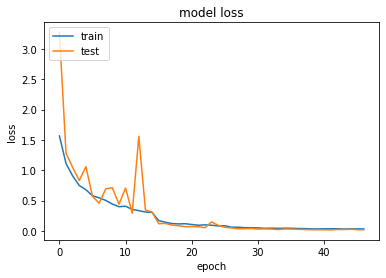

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

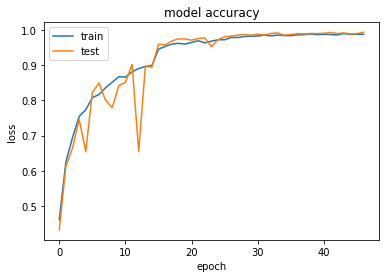

In [17]:
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
import shutil
from IPython.display import FileLink

In [19]:
os.chdir(r'/kaggle/working/')
FileLink(r'best_model.h5')

/kaggle/working/best_model.h5